In [ ]:
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.ndimage import gaussian_filter
from google.colab import drive

import os
import pandas as pd
import glob
import random
import math
import csv
import shutil



In [ ]:
outputResolution  = (168,224)
minScale = .75
maxScale = 1
trainingSize = 30
testingSize = 3
dataset_name = "PINTOBEANS_PEBBLES_PISTACHIO2"

In [ ]:
directoryPath = "/content/drive/MyDrive/CE_Capstone_QA_2022-2023/DataCreation"
defectivePath = os.path.join(directoryPath,"defective")
goodPath = os.path.join(directoryPath,"good")
backgroundPath = os.path.join(directoryPath,"background_all")
syntheticPath = os.path.join(directoryPath,"synthetic_images")
datasetPath = os.path.join(directoryPath,dataset_name)
out_folder_test = os.path.join(datasetPath, 'test')
out_folder_train = os.path.join(datasetPath, 'train')
out_folder_processed = os.path.join(datasetPath, 'processed')


In [ ]:
if os.path.exists(datasetPath):
  print('Output folders exist. Delete!')
  !rm -r $datasetPath
  !mkdir $datasetPath
  !mkdir $out_folder_test
  !mkdir $out_folder_train
  !mkdir $out_folder_processed
else:
  !mkdir $datasetPath
  !mkdir $out_folder_test
  !mkdir $out_folder_train
  !mkdir $out_folder_processed

Output folders exist. Delete!


In [ ]:
np.set_string_function(lambda x: repr(x).replace('(', '').replace(')', '')
                       .replace('array', '').replace("       ", ' '), repr=False)

In [ ]:
def image_transform_opencv(img, brightness_range=(0.95, 1.05), saturation_range=(0.85, 1.15),
                           contrast_range=(0.85, 1.15), hue_range=(-0.2, 0.2), grayscale_prob=0.15,
                           blur_kernel_size=(5, 5), blur_sigma_range=(0.5, 5),noise_stddev=(.3,.75)):
    
    def adjust_brightness_contrast_hue_saturation(img, b, c, h, s):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 0] = (hsv[:, :, 0] + h * 180) % 180
        hsv[:, :, 1] *= s
        hsv[:, :, 2] *= b
        hsv = np.clip(hsv, 0, 255)
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
        img = cv2.addWeighted(img, c, img, 0, -128 * (1 - c))
        return img

    def apply_grayscale(img, prob):
        if np.random.rand() < prob:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        return img

    def apply_gaussian_blur(img, kernel_size, sigma_range):
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        return cv2.GaussianBlur(img, kernel_size, sigma)
    def apply_gaussian_noise(img, stddev):
        noise = np.random.normal(0, stddev, img.shape).astype(np.uint8)
        return cv2.add(img, noise)

    brightness = np.random.uniform(brightness_range[0], brightness_range[1])
    contrast = np.random.uniform(contrast_range[0], contrast_range[1])
    hue = np.random.uniform(hue_range[0], hue_range[1])
    saturation = np.random.uniform(saturation_range[0], saturation_range[1])
    noise = np.random.uniform(noise_stddev[0], noise_stddev[1])

    img = apply_gaussian_noise(img, noise)
    img = adjust_brightness_contrast_hue_saturation(img, brightness, contrast, hue, saturation)
    img = apply_grayscale(img, grayscale_prob)
    img = apply_gaussian_blur(img, blur_kernel_size, blur_sigma_range)
    

    return img

In [ ]:


def Jitter_image(img, brightness_factor=0.1, contrast_factor=0.1, saturation_factor=0.1, noise_stddev=10, alpha=36, sigma=4):
    def adjust_brightness_contrast_saturation(img, b, c, s):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s_channel, v = cv2.split(hsv)
        s_channel = cv2.addWeighted(s_channel, 1 + s, s_channel, 0, 0)
        v = cv2.addWeighted(v, 1 + b, v, 0, 0)
        v = cv2.addWeighted(v, 1 + c, v, -128 * (1 + c), 0)
        return cv2.cvtColor(cv2.merge([h, s_channel, v]), cv2.COLOR_HSV2BGR)

  

    b_factor = 1 + brightness_factor * (np.random.rand() * 2 - 1)
    c_factor = 1 + contrast_factor * (np.random.rand() * 2 - 1)
    s_factor = saturation_factor * (np.random.rand() * 2 - 1)
    img = adjust_brightness_contrast_saturation(img, b_factor, c_factor, s_factor)

   # noise = np.random.normal(0, noise_stddev, img.shape).astype(np.uint8)
   # img = cv2.add(img, noise)

   # img = elastic_transform(img, alpha, sigma)

    return img

In [ ]:
def trim_black_border(image, border_color=(0, 0, 0)):
    mask = np.all(image == border_color, axis=-1)

    rows = np.flatnonzero(np.any(~mask, axis=1))
    cols = np.flatnonzero(np.any(~mask, axis=0))

    if rows.size == 0 or cols.size == 0:
        return image

    return image[rows.min():rows.max()+1, cols.min():cols.max()+1]

In [ ]:
#@ ImageLoader
def loadImages(path, reshape, trim, removeBG):
  os.chdir(path)
  images = []
  for image_file in glob.glob("*.png") + glob.glob("*.jpg"):
    # Read the image using OpenCV
    img = cv2.imread(image_file)
    if removeBG == True and  not "no_bg" in image_file:
      img = remove_background(img)
    if reshape == True:
      img = cv2.resize(img, outputResolution)
    if trim:
      img = trim_black_border(img)
    # Append the image to the list
    images.append(img)
   # cv2_imshow(img)
    #print(img.shape)
  return images

In [ ]:
def getCroppedImg(img, margin_l = 15, margin_b = 15):
  cropList = []
  blurred = cv2.GaussianBlur(img,(11,11),0) 
  # convert the image to grayscale
  gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
  # apply thresholding on the gray image to create a binary image
  ret,thresh = cv2.threshold(gray,127,255,0)
  # find the contours
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #x = cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
  #cv2_imshow(x)
  for i in range(len(contours)):
  # take the first contour
    cnt = contours[i]
  # compute the bounding rectangle of the contour
    x,y,w,h = cv2.boundingRect(cnt)
    area = w*h
    if(area < 100):
      break
    cropRadius = (w+h)//2
    centerX = x + w//2
    centerY = y + h//2

    lowX = centerX-cropRadius
    highX = centerX+cropRadius
    lowY = centerY-cropRadius
    highY = centerY+cropRadius
    
    if(lowX < 0):
      highX = 2*cropRadius - 1
      lowX = 0
    if(highX > img.shape[1]-1):
      lowX = img.shape[1]-1 - 2*cropRadius
      highX = img.shape[1]-1

    if(lowY < 0):
      highY = 2*cropRadius - 1
      lowY = 0
    if(highY > img.shape[0]-1):
      #print(highY - img.shape[0]-1)
      lowY = img.shape[0]-1 - 2*cropRadius
      highY = img.shape[0]-1
    bottom_L = x-margin_l
    bottom_B = y - margin_b
    crop = img[lowY:highY,lowX:highX]
    cropList.append(crop)

In [ ]:
def remove_background(img):
   # alpha_channel = np.ones(img.shape[:2], dtype=np.uint8) * 255
  #  img = cv2.merge((img, alpha_channel))
     # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Threshold the image to create a binary image
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # Erode the binary image to make the contours more forgiving
    kernel = np.ones((3,3), np.uint8)
    # thresh = cv2.erode(thresh, kernel, iterations=1)
    # Dilate the binary image to increase the size of the object
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    # Find contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    # Create a mask with the same size as the image
    mask = np.zeros_like(img)
    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255,255,255), -1)
    # Create a black background
    background = np.zeros_like(img)
   # background[..., 3] = 0 
    # Use bitwise_and to remove the background outside the contour
    result = cv2.bitwise_and(img, mask) + background
    # Apply Gaussian Blur to add feathering and fade to the borders
    #result = cv2.GaussianBlur(result, (3,3), 0)

    return result

    

In [ ]:
def distance(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5


In [ ]:
def scale_image(image):
    scale = random.uniform(minScale, maxScale);
    rows, cols, _ = image.shape
    new_rows = int(rows * scale)
    new_cols = int(cols * scale)

    # Scale the image using the specified factors
    scaled_image = cv2.resize(image, (new_cols, new_rows))

    return scaled_image

In [ ]:
def paste_synthetic_image(bg, image, position_list, min_distance=50, max_iterations=50):
    bg = bg.copy()
    rows, cols, imd = image.shape
    angle = random.uniform(0, 180)  # Random angle between 0 and 180 degrees

    # Calculate the new size of the rotated image
    radians = math.radians(angle)
    sin = abs(math.sin(radians))
    cos = abs(math.cos(radians))
    new_rows = int((rows * cos) + (cols * sin))
    new_cols = int((rows * sin) + (cols * cos))

    # Get the rotation matrix with the updated center
    M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)

    # Update the translation part of the rotation matrix
    M[0, 2] += (new_cols - cols) // 2
    M[1, 2] += (new_rows - rows) // 2

    # Rotate the image using the rotation matrix
    image = cv2.warpAffine(image, M, (new_cols, new_rows))
    
    image = scale_image(image);
    
    rows, cols, imd = image.shape
    pos_len = len(position_list)
    added = False
    for _ in range(max_iterations):
      pRow, pCol = random.randint(0, bg.shape[0] - rows), random.randint(0, bg.shape[1] - cols), 
      if pos_len == 0:
        added = True
        position_list.append((pRow + rows//2, pCol + cols// 2))
        break


      if not any([distance((pRow + rows//2, pCol + cols// 2), center) < min_distance for center in position_list]):
        added = True
        position_list.append((pRow + rows//2, pCol + cols// 2))
        break


    if (pos_len == len(position_list) or added == False):
      print("could not find match")
      return bg, None, None, None, None
   
    good_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, good_mask = cv2.threshold(good_mask, 1, 255, cv2.THRESH_BINARY)
    
    # Create a mask for the image
    mask = cv2.merge((good_mask, good_mask, good_mask))

    # Paste the image onto the background
    bg[pRow:pRow + rows, pCol:pCol + cols] = cv2.bitwise_and(image, mask) + cv2.bitwise_and(bg[pRow:pRow + rows, pCol:pCol + cols], cv2.bitwise_not(mask))

    return bg, pCol, pRow, pCol + cols, pRow + rows

In [ ]:
def resize_if_over_threshold(img, size_threshold, resize_factor=0.35):
    
    # Get the image size (height, width)
    height, width, _ = img.shape

    # Check if the image size is over the threshold
    if height * width > size_threshold:
        # Resize the image
        new_height = int(height * resize_factor)
        new_width = int(width * resize_factor)
        resized_img = cv2.resize(img, (new_width, new_height))
        cv2_imshow(resized_img)
        return resized_img

    # If the image size is not over the threshold, return the original image
    return img

In [ ]:
defectiveList = loadImages(defectivePath, False, True, True)
goodList = loadImages(goodPath, False, True, True)
bgList = loadImages(backgroundPath,True, False,False)


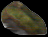

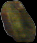

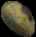

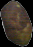

In [ ]:
defectiveList = [resize_if_over_threshold(img, 2000) for img in defectiveList]

In [ ]:

#create csv
# create csv files
header = "img_name,label,width,height,x0,y0,x1,y1,num_of_boxes,img_width,img_height,bb_x0,bb_y0,bb_x1,bb_y1"


fptrain = open(os.path.join(out_folder_processed, 'train_info.csv'), 'w')
fptrain.write(header)
fptest = open(os.path.join(out_folder_processed, 'test_info.csv'), 'w')
fptest.write(header)



97

In [ ]:
cnt = 0
for i in range(trainingSize):
  position_list = []
  bgChoice = random.choice(bgList)
  numGood = random.randint(0,3)
  numBad = random.randint(1,3)
  for i in range(numGood):
   bgChoice, _,_,_,_ = paste_synthetic_image(bgChoice, random.choice(goodList), position_list, min_distance = 50, max_iterations = 100)
   

  csv_info = {'label': np.empty(0),
                'width': np.empty(0), 'height': np.empty(0), 'x0': np.empty(0), 'y0': np.empty(0),
                'x1': np.empty(0), 'y1': np.empty(0), 'num_of_boxes': 0, 'img_width': 0,
                'img_height': 0, 'bb_x0': 0, 'bb_y0': 0, 'bb_x1': 0, 'bb_y1': 0}
  for i in range(numBad):
    bgChoice, box_x0, box_y0, box_x1, box_y1  = paste_synthetic_image(bgChoice, random.choice(defectiveList), position_list, min_distance = 50, max_iterations = 100)
    if box_x0 is not None and box_y0 is not None and box_x1 is not None and box_y1 is not None:
            #cv2.rectangle(bgChoice, (xd1, yd1), (xd2, yd2), (0, 255, 0), 2)
      csv_info['width'] = np.append(csv_info['width'], box_x1 - box_x0)
      csv_info['height'] = np.append(csv_info['height'], box_y1 - box_y0)
      csv_info['x0'] = np.append(csv_info['x0'], box_x0)
      csv_info['y0'] = np.append(csv_info['y0'], box_y0)
      csv_info['x1'] = np.append(csv_info['x1'], box_x1)
      csv_info['y1'] = np.append(csv_info['y1'], box_y1)

      csv_info['num_of_boxes'] = csv_info['num_of_boxes'] + 1
      csv_info['img_width'] = outputResolution[0]
      csv_info['img_height'] = outputResolution[1]
      csv_info['bb_x0'] = min(csv_info['x0'])
      csv_info['bb_y0'] = min(csv_info['y0'])
      csv_info['bb_x1'] = max(csv_info['x1'])
      csv_info['bb_y1'] = max(csv_info['y1'])

      csv_info['label'] = np.append(csv_info['label'], 1.0)
  fname = 'pebble_' + str(cnt) + '__' + str(box_x0) + '_' + str(box_y0) + '_' + str(box_x1) + '_' + str(box_y1) + '.jpg'

  csv_line = '\n' + fname

  for i, item in enumerate(csv_info):
      if item in {'label', 'width', 'height', 'x0', 'y0', 'x1', 'y1'}:
          csv_line += ',"' + str(csv_info[item]) + '"'
      else:
          csv_line += ',' + str(csv_info[item])

  cnt += 1
  if(cnt % 100 == 0):
    print("count = ",cnt)
  bgChoice = image_transform_opencv(bgChoice)
  #cv2_imshow(bgChoice)
  cv2.imwrite(os.path.join(out_folder_train, fname),bgChoice)
  fptrain.write(csv_line)
fptrain.close();
  

In [ ]:
cnt = 0
for i in range(testingSize):
  position_list = []
  bgChoice = random.choice(bgList)
  numGood = random.randint(0,3)
  numBad = random.randint(1,3)
  for i in range(numGood):
   bgChoice, _,_,_,_ = paste_synthetic_image(bgChoice, random.choice(goodList), position_list, min_distance = 50, max_iterations = 100)
   

  csv_info = {'label': np.empty(0),
                'width': np.empty(0), 'height': np.empty(0), 'x0': np.empty(0), 'y0': np.empty(0),
                'x1': np.empty(0), 'y1': np.empty(0), 'num_of_boxes': 0, 'img_width': 0,
                'img_height': 0, 'bb_x0': 0, 'bb_y0': 0, 'bb_x1': 0, 'bb_y1': 0}
  for i in range(numBad):
    bgChoice, box_x0, box_y0, box_x1, box_y1  = paste_synthetic_image(bgChoice, random.choice(defectiveList), position_list, min_distance = 50, max_iterations = 100)
    if box_x0 is not None and box_y0 is not None and box_x1 is not None and box_y1 is not None:
            #cv2.rectangle(bgChoice, (xd1, yd1), (xd2, yd2), (0, 255, 0), 2)
      csv_info['width'] = np.append(csv_info['width'], box_x1 - box_x0)
      csv_info['height'] = np.append(csv_info['height'], box_y1 - box_y0)
      csv_info['x0'] = np.append(csv_info['x0'], box_x0)
      csv_info['y0'] = np.append(csv_info['y0'], box_y0)
      csv_info['x1'] = np.append(csv_info['x1'], box_x1)
      csv_info['y1'] = np.append(csv_info['y1'], box_y1)

      csv_info['num_of_boxes'] = csv_info['num_of_boxes'] + 1
      csv_info['img_width'] = outputResolution[0]
      csv_info['img_height'] = outputResolution[1]
      csv_info['bb_x0'] = min(csv_info['x0'])
      csv_info['bb_y0'] = min(csv_info['y0'])
      csv_info['bb_x1'] = max(csv_info['x1'])
      csv_info['bb_y1'] = max(csv_info['y1'])

      csv_info['label'] = np.append(csv_info['label'], 1.0)
  fname = 'pebble_' + str(cnt) + '__' + str(box_x0) + '_' + str(box_y0) + '_' + str(box_x1) + '_' + str(box_y1) + '.jpg'

  csv_line = '\n' + fname

  for i, item in enumerate(csv_info):
      if item in {'label', 'width', 'height', 'x0', 'y0', 'x1', 'y1'}:
          csv_line += ',"' + str(csv_info[item]) + '"'
      else:
          csv_line += ',' + str(csv_info[item])

  cnt += 1
  if(cnt % 100 == 0):
    print("count = ",cnt)
  cv2.imwrite(os.path.join(out_folder_test, fname),bgChoice)
  fptest.write(csv_line)
fptest.close();

In [ ]:
cd "/content/drive/MyDrive/CE_Capstone_QA_2022-2023/DataCreation"


/content/drive/MyDrive/CE_Capstone_QA_2022-2023/DataCreation


In [ ]:
!zip -r Pintobeans.zip PINTOBEANS_PEBBLES_PISTACHIO2//


  adding: PINTOBEANS_PEBBLES_PISTACHIO2// (stored 0%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//test/ (stored 0%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//test/pebble_0__23_52_54_103.jpg (deflated 1%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//test/pebble_1__77_35_106_63.jpg (deflated 2%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//test/pebble_2__54_85_81_116.jpg (deflated 2%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/ (stored 0%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_0__4_171_34_201.jpg (deflated 2%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_1__16_52_61_98.jpg (deflated 1%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_2__9_197_29_219.jpg (deflated 1%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_3__47_173_87_209.jpg (deflated 2%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_4__9_139_56_180.jpg (deflated 1%)
  adding: PINTOBEANS_PEBBLES_PISTACHIO2//train/pebble_5__116_54_138_79.jpg (deflated 1%)
  adding: PINTOBEANS_PEBBLES_PISTACHI